# contents

# 1. Data preprocess

# 2. Single variable explore
### 2.1 continue variables
### 2.2 categorical variablse
# 3. Transform raw data & create cluster
### 3.1 transform data
### 3.2 Kmeans K-tunning
### 3.3 K-adjust depends on business purpose
# 4. Un-supervised learning Functions
### 4.1 Business intuition
### 4.2 Detect outlier
### 4.3 Improve supervised learning
### 4.4 Time series analysis

In [1]:
import numpy as np
import pandas as pd
import scipy

import nltk
import gensim

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
import seaborn as sns

import holidays

# 1.Data preprocess
## same as supervised-learning,except:
 - 1.Did not fill nan value,because I need analysis those empty value;
 - 2.Keep important features, because I wanna explore more intuitive information about those features, and those features selected by domain knowlege.

In [2]:
df=pd.read_csv('Data/Data_I-hope.csv')
df = df[(df["ProjectStage"] == 'Complete')]
df = df.dropna(subset=['PlanFinishDate'])

mi_holidays = holidays.UnitedStates(state='MI')
start = df['PlanStartDate'].astype(str)
end = df['ActualFinishDate'].astype(str)
bus = []
holi = []
dur = []
start_list = start.tolist()
end_list = end.tolist()
for i in range(len(start_list)):
    holi.append(len(mi_holidays[start_list[i]: end_list[i]]))
    bus.append(np.busday_count(start_list[i], end_list[i]))

zip_object = zip(bus, holi)
for list1_i, list2_i in zip_object:
    dur.append(list1_i-list2_i)
df['Duration'] = dur


def met_sla(df):
    if df['Duration'] <= df['SLA']:
        val = 1
    elif df['Duration'] > df['SLA']:
        val = 0
    return val
df['Met_SLA'] = df.apply(met_sla, axis=1)

duration = []
for item in df['Duration'].to_list():
    if abs(int(item)) >=0 and abs(int(item)) < 50:
        duration.append(1)
    elif abs(int(item)) >=50 and abs(int(item)) < 100:
        duration.append(2)
    elif abs(int(item)) >=100 and abs(int(item)) < 150:
        duration.append(3)
    elif abs(int(item)) >=150 and abs(int(item)) < 200:
        duration.append(4)
    elif abs(int(item)) >=200 and abs(int(item)) < 250:
        duration.append(5)
    elif abs(int(item)) >=250 and abs(int(item)) < 300:
        duration.append(6)
    elif abs(int(item)) >=300 and abs(int(item)) < 350:
        duration.append(7)
    elif abs(int(item)) >=350 and abs(int(item)) < 400:
        duration.append(8)
    elif abs(int(item)) >=400:
        duration.append(9)
df['DurationCat'] = duration

df=df.rename(columns={"CategoryID_y": "CategoryID","Division_y":"Division"})
keep_cols=['Met_SLA','SLA','Hours','ProjectType','CreatedBy','Division','CategoryID',
            'BuyerName','Planned','LevelCalc','WorkPerformedFor','FedReview','DurationCat']

df=df[keep_cols]
print(df.shape)
df.head()

(4026, 13)


,Met_SLA,SLA,Hours,ProjectType,CreatedBy,Division,CategoryID,BuyerName,Planned,LevelCalc,WorkPerformedFor,FedReview,DurationCat
1,0,63,7.0,CN,Gibrilm,PROF,165,JW3,NaN,2,431,False,2
2,1,63,10.0,CN,keilenn,PROF,165,JW3,NaN,2,431,False,1
3,1,63,7.0,CN,keilenn,PROF,165,JW3,NaN,2,391,False,1
4,1,138,120.0,RFP,NaN,PROF,165,SDC,NaN,2,591,False,2
5,1,138,40.0,RFP,EdgettC,PROF,165,CK1,NaN,2,11,False,2


In [3]:
num_cols=['SLA','Hours','LevelCalc','DurationCat']
cat_cols=['Met_SLA','ProjectType','CreatedBy','Division','CategoryID','BuyerName',
          'Planned','WorkPerformedFor','FedReview']

for col in num_cols:
    df[col]=pd.to_numeric(df[col],errors='coerce')
    df[col]=df[col].fillna(-1)
    
for col in cat_cols:
    df[col]=df[col].fillna('missing')

# 2.single variable explore

## 2.1 continue variables

In [4]:
def prepare_graphdata_(col):

    arr1=df[col]

    upper_=df[col].quantile(0.95)
    lower_=df[col].quantile(0.05)
    arr2=np.where(arr1>upper_,upper_,arr1)
    arr2=np.where(arr2<lower_,lower_,arr2)

    min_=arr2.min()
    max_=arr2.max()
    arr3=(arr2-min_)/(max_-min_)

    min_=arr2.min()
    arr4=np.log(arr2-min_+1)
    min_=arr4.min()
    max_=arr4.max()
    arr4=(arr4-min_)/(max_-min_)
    
    return arr1,arr2,arr3,arr4

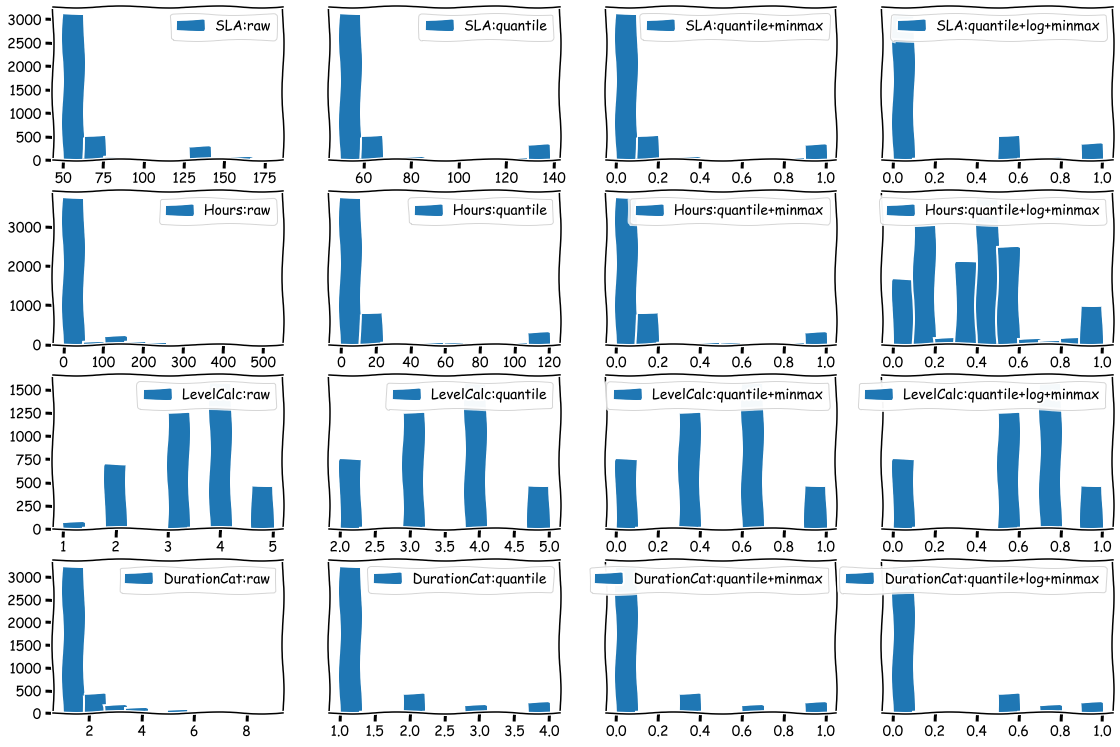

In [5]:
label_types=['raw','quantile','quantile+minmax','quantile+log+minmax']

with plt.xkcd(): 
    plt.close()
    fig, axs = plt.subplots(4, 4, figsize=(19,13))
    
    for i in range(len(num_cols)):
        col=num_cols[i]
        arrs=prepare_graphdata_(col)
        label_names=[col+':'+x for x in label_types]
        
        for j in [0,1,2,3]:
            label_name=label_names[j]
            
            axs[i,j].hist(arrs[j],label=label_name)
            axs[i,j].legend(loc='upper right')
            
            if j>0:
                axs[i,j].tick_params(left=False,labelleft=False)

## 2.2 categorical variablse

In [6]:
def keep_catgorical_(col,cutoff_=100):
    if cutoff_==0:
        return np.array(df[col],dtype=str)
    
    tmp=df.groupby([col]).agg({'Met_SLA':'count'})
    keep_group=list(tmp[tmp['Met_SLA']>=cutoff_].index)
    res=df[[col]].copy(deep=True)
    res.loc[~res[col].isin(keep_group),col]='other'
    return np.array(res[col],dtype=str)

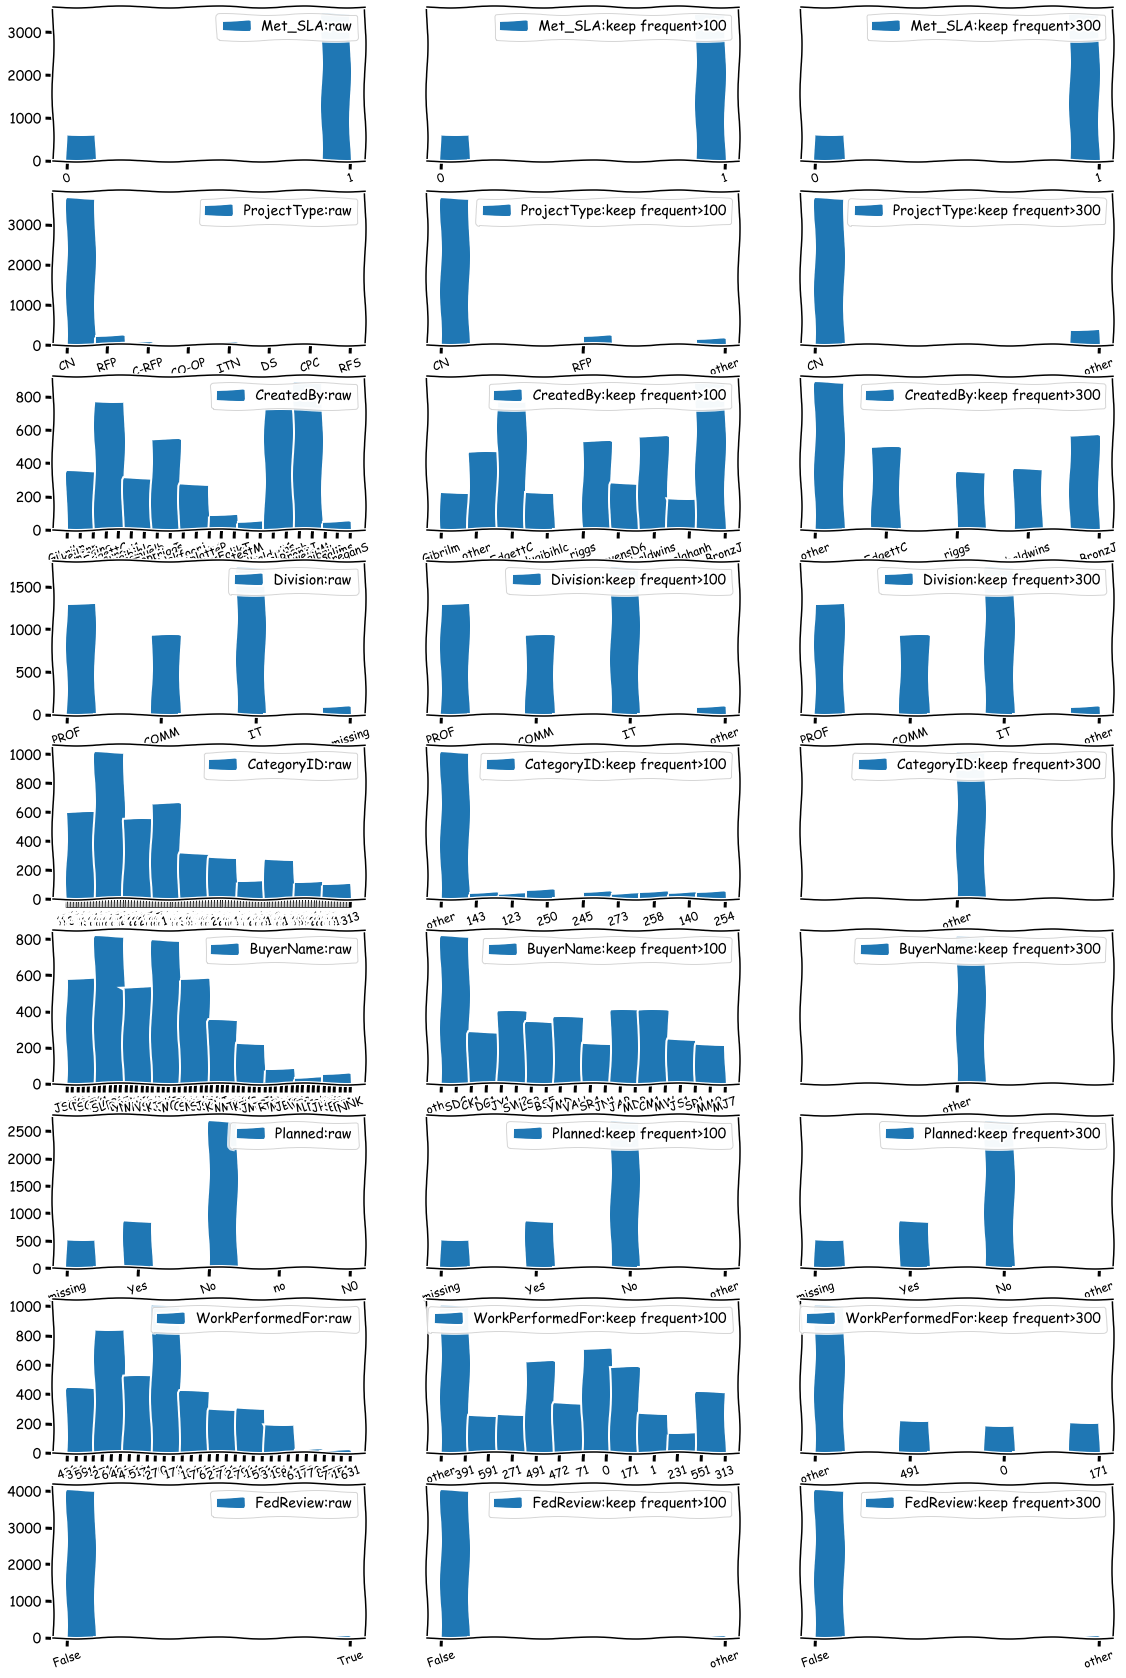

In [7]:
label_types=['raw','keep frequent>100','keep frequent>300']
cutoff_values=[0,100,300]

with plt.xkcd(): 
    plt.close()
    fig, axs = plt.subplots(9, 3, figsize=(19,30))
    
    for i in range(len(cat_cols)):
        col=cat_cols[i]
        label_names=[col+':'+x for x in label_types]
        
        for j in [0,1,2]:
            label_name=label_names[j]
            
            arr=keep_catgorical_(col,cutoff_=cutoff_values[j])
            axs[i,j].hist(arr,label=label_name)
            axs[i,j].legend(loc='upper right')
            axs[i,j].tick_params(axis="x", rotation=20,labelsize='small')
            if j>0:
                axs[i,j].tick_params(left=False,labelleft=False)

# 3. transform raw data & create cluster
 - transform raw data depends on single variable explore result
 - use kmeans and GMM cluster our project

In [8]:
df_ori=df.copy(deep=True)

## 3.1 transform data

### 3.1.1 transform depends on single variable explore

In [9]:
#--------------------------------------
for col in num_cols:
    df[col]=pd.to_numeric(df[col],errors='coerce')
    df[col]=df[col].fillna(-1)
    
    upper_=df[col].quantile(0.95)
    lower_=df[col].quantile(0.05)
    df.loc[df[col]>upper_,col]=upper_
    df.loc[df[col]<lower_,col]=lower_

    min_=df[col].min()
    df[col]=np.log(df[col]-min_+1)
    
    min_=df[col].min()
    max_=df[col].max()
    df[col]=(df[col]-min_)/(max_-min_)*2 # *2:increase influence by continue variables when clustering
    
#---------------------------------------    
for col in cat_cols:
    tmp=df.groupby([col]).agg({'Met_SLA':'count'})
    keep_group=list(tmp[tmp['Met_SLA']>=100].index)
    df.loc[~df[col].isin(keep_group),col]='other'

### 3.1.2 transform cat cols to one-hot encoding

In [10]:
# one-hot encoding
df=pd.get_dummies(df, columns=cat_cols, drop_first=False)
print(df.shape)
df.head(3)

(4026, 70)


,SLA,Hours,LevelCalc,DurationCat,Met_SLA_0,Met_SLA_1,ProjectType_CN,ProjectType_RFP,ProjectType_other,CreatedBy_BronzJ,...,WorkPerformedFor_271,WorkPerformedFor_313,WorkPerformedFor_391,WorkPerformedFor_472,WorkPerformedFor_491,WorkPerformedFor_551,WorkPerformedFor_591,WorkPerformedFor_other,FedReview_False,FedReview_other
1,1.175884,0.914744,0.0,1.0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,1,1,0
2,1.175884,1.034511,0.0,0.0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,1,1,0
3,1.175884,0.914744,0.0,0.0,0,1,1,0,0,0,...,0,0,1,0,0,0,0,0,1,0


## 3.2 Kmeans K-tunning

In [11]:
def draw_elbow_rule_(tmp):
    tmp=pd.DataFrame(tmp,columns=['k','score'])
    
    sns.set_style("ticks")
    sns.relplot(x='k', y='score', hue="k", 
                alpha=.7, data=tmp)

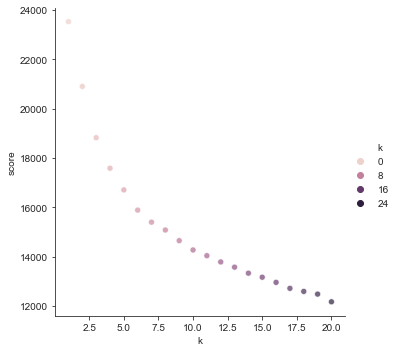

In [12]:
tmp=[]
X=np.array(df.drop('DurationCat',axis=1))
for k in range(1,21,1):
    m=KMeans(n_clusters=k, random_state=0).fit(X)
    s=m.score(X)
    tmp.append([k,-s])   
draw_elbow_rule_(tmp)

## 3.3 K-adjust depends on business purpose
 - sometimes, distance decrease can not help people make good decision
 - for example, too many clusters to analyse.

In [13]:
df_ori['kmeans_cluster']=KMeans(n_clusters=3, random_state=0).fit_predict(X)
df['kmeans_cluster']=KMeans(n_clusters=3, random_state=0).fit_predict(X)

# 4. Un-supervised learning Functions

## 4.1 Business intuition
 - we really concern about whther a project meet SLA in business.
 - so we analysis varibale distribution in each cluster, we pay more attention to the key variable 'Met_SLA_ratio'.
 - we calculate the key variable use the formula #projects meet SLA in the cluster / #projects in the cluster

In [14]:
tmp=df_ori.groupby(['kmeans_cluster'])\
          .agg({'SLA':['mean'],
                'Hours':['mean'],
                'LevelCalc':['mean'],
                'DurationCat':['mean'],
                'Met_SLA':['mean'],
                'ProjectType':[lambda x:x.value_counts().index[0]],
                'CreatedBy':[lambda x:x.value_counts().index[0]],
                'Division':[lambda x:x.value_counts().index[0]],
                'CategoryID':[lambda x:x.value_counts().index[0]],
                'Planned':[lambda x:x.value_counts().index[0]],
                'WorkPerformedFor':[lambda x:x.value_counts().index[0]],
                'FedReview':[lambda x:x.value_counts().index[0]]})

tmp=tmp.rename({'Met_SLA':'Met_SLA_ratio'},axis=1)
tmp=tmp.reset_index()
tmp.columns=[x[0] for x in tmp.columns]

### 4.1.1 continue variable's relative value in each group

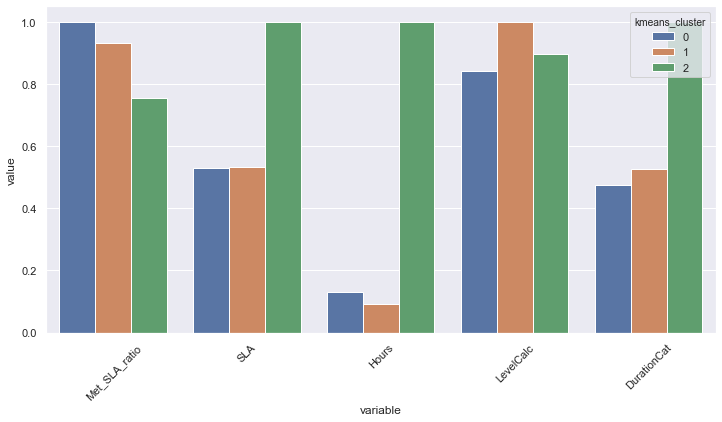

In [15]:
graph_=tmp.copy(deep=True)

melt_features=['Met_SLA_ratio','SLA','Hours','LevelCalc','DurationCat']
for col in melt_features:
    graph_[col]=graph_[col]/graph_[col].max()
graph_=pd.melt(graph_, id_vars=['kmeans_cluster'], value_vars=melt_features)

sns.set(rc={'figure.figsize':(12,6)})
chart=sns.barplot(x="variable", y="value", hue="kmeans_cluster", data=graph_)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
plt.show()

### 4.1.2 catgorical variable's distribution in each group

In [16]:
#too many values in some catgorical features, so reduce again
df_ori_reduce=df_ori.copy(deep=True)
for col in cat_cols:
    tmp=df_ori_reduce.groupby([col]).agg({'Met_SLA':'count'})
    keep_group=list(tmp[tmp['Met_SLA']>=100].index)
    df_ori_reduce.loc[~df_ori_reduce[col].isin(keep_group),col]='other'

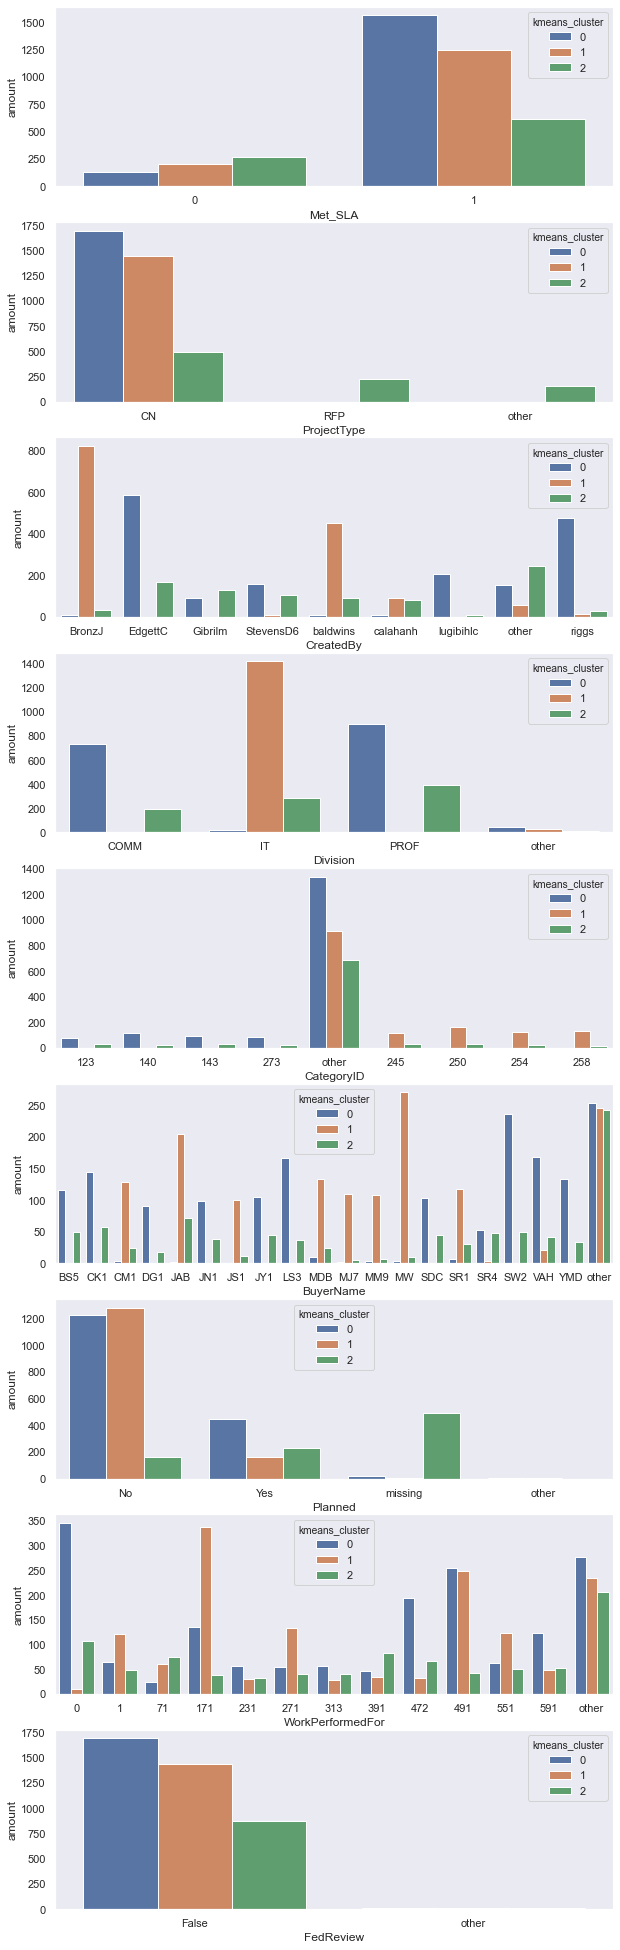

In [17]:
sns.set(rc={'figure.figsize':(10,35)})
f, axes = plt.subplots(9, 1)

cat_features=['Met_SLA','ProjectType','CreatedBy','Division','CategoryID',
              'BuyerName','Planned','WorkPerformedFor','FedReview']
for col in cat_features:
    tmp=df_ori_reduce.groupby(['kmeans_cluster',col]).agg({'SLA':'count'}).reset_index()
    tmp.columns=['kmeans_cluster',col,'amount']
    sns.barplot(x=col, y='amount', hue='kmeans_cluster', data=tmp, ax=axes[cat_features.index(col)])\
    .grid(False)    

### 4.1.3 conclusion

### cluster 2
 - projects in c-2 is more big than c-0 and c-1 [SLA and Hours is higher]
 - projects in c-2 seems unlikely to meet SLA.  [Met_SLA]
 - projects in c-2 are diverse, only c-2 includes projects type like 'RFP'.
 - variable-Planned has more empty value, maybe this is why c-2 unlikely to meet SLA.

## 4.2 Detect outlier

### 4.2.1 PCA & VIS

In [18]:
# Z-scale
X=np.array(df.drop(['kmeans_cluster'],axis=1))
mean_=np.mean(X,axis=0)
std_=np.std(X,axis=0)
X=(X-mean_)/std_

pca_model=PCA(n_components=2)
X=pca_model.fit_transform(X)
df[['pc1','pc2']]=X
df_ori[['pc1','pc2']]=X
print('first 2 principal components explained '+
      str(pca_model.explained_variance_ratio_.sum())+ ' variance in the original data.')

first 2 principal components explained 0.1368475979942328 variance in the original data.


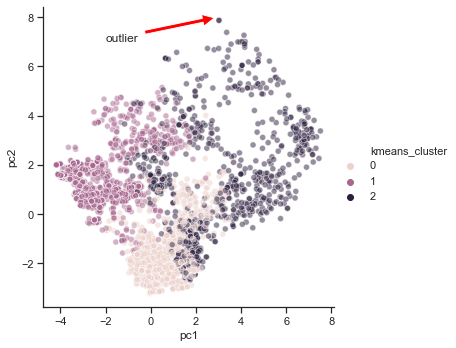

In [19]:
def draw_cluster_(cluster_colname):
    sns.set_style("ticks")
    sns.relplot(x="pc1", y="pc2", hue=cluster_colname,
                alpha=.5,data=df)
    plt.annotate('outlier', xy=(3, 8),
                 xytext=(-2, 7),arrowprops=dict(facecolor='red',
                                shrink=0.05),xycoords="data",)
    
draw_cluster_('kmeans_cluster')

### 4.2.2 outlier analysis

In [20]:
df_ori[df_ori['pc2']>7.8]

,Met_SLA,SLA,Hours,ProjectType,CreatedBy,Division,CategoryID,BuyerName,Planned,LevelCalc,WorkPerformedFor,FedReview,DurationCat,kmeans_cluster,pc1,pc2
3787,0,165,120.0,C-RFP,baldwins,IT,254,JAB,No,4,491,True,9,2,3.021006,7.864316
3806,0,165,120.0,C-RFP,baldwins,IT,254,JAB,No,4,491,True,8,2,3.021006,7.864316


In [21]:
df_ori.describe()

,Met_SLA,SLA,Hours,CategoryID,LevelCalc,WorkPerformedFor,DurationCat,kmeans_cluster,pc1,pc2
count,4026.000000,4026.000000,4026.000000,4026.000000,4026.000000,4026.000000,4026.000000,4026.000000,4.026000e+03,4.026000e+03
mean,0.850720,59.848733,14.660457,184.007700,3.420268,331.048684,1.423994,0.797814,-8.471448e-17,-1.341313e-16
std,0.356408,25.762464,36.521015,87.589932,0.949783,231.909881,1.117811,0.774664,2.286576e+00,2.086452e+00
min,0.000000,50.000000,-1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,-4.174485e+00,-3.223527e+00
25%,1.000000,50.000000,0.000000,123.000000,3.000000,171.000000,1.000000,0.000000,-1.678644e+00,-1.842405e+00
50%,1.000000,50.000000,6.000000,216.000000,4.000000,313.000000,1.000000,1.000000,-1.903134e-02,1.164353e-01
75%,1.000000,50.000000,10.000000,255.000000,4.000000,491.000000,1.000000,1.000000,1.230693e+00,1.438463e+00
max,1.000000,180.000000,524.000000,315.000000,5.000000,791.000000,9.000000,2.000000,7.509903e+00,7.864316e+00


 - those 2 projects have sufficient time to complete [SLA=165, almost the highest SLA(180)]
 - but those project finally did not meet SLA [Met_SLA =0]
 - next step we need check data again, if data is fine, then this is problem in business and we need figure out why!

## 4.3 improve supervised learning

### 4.3.1 prepare data (same as supervised, except how to fill nan value)

In [22]:
df_=df_ori.copy(deep=True)
for col in cat_cols:
    df_[col]=df_[col].astype(str)
    tmp_dict=dict(zip(set(df_[col]),range(len(set(df_[col])))))
    df_[col]=df_[col].map(tmp_dict)

x_col=['Met_SLA','SLA','Hours','ProjectType','CreatedBy','Division','CategoryID','BuyerName',
       'Planned','LevelCalc','WorkPerformedFor','FedReview']
x_col_uns=x_col+['kmeans_cluster','pc1','pc2']
y_col=['DurationCat']

#-----------------------------------
X_uns,y=df_[x_col_uns],df_[y_col]
X_uns_train, X_uns_test, y_train, y_test = train_test_split(X_uns, y, test_size=0.33, random_state=1)
X_test=X_uns_test[x_col].copy(deep=True)

oversample = SMOTE(random_state=42, sampling_strategy={1:2155, 2:2000, 3:2000, 4:2000, 5:2000, 
                                                       6:2000, 7:2000, 8:2000, 9:2000})
X_uns_s, y_s = oversample.fit_resample(X_uns_train, y_train)
X_s=X_uns_s[x_col].copy(deep=True)

print(X_s.shape, X_uns_s.shape, y_s.shape)
print(X_test.shape, X_uns_test.shape, y_test.shape)

(18155, 12) (18155, 15) (18155, 1)
(1329, 12) (1329, 15) (1329, 1)


### 4.3.2 training model

In [23]:
clf=RandomForestClassifier(max_depth=7, n_estimators=1000, max_features=1,random_state=42)
clf.fit(X_s, np.array(y_s).reshape(-1))
print('without unsuper- test AUC= ',clf.score(X_test,y_test))

without unsuper- test AUC=  0.8841234010534236


In [24]:
clf=RandomForestClassifier(max_depth=7, n_estimators=1000, max_features=1,random_state=42)
clf.fit(X_uns_s, np.array(y_s).reshape(-1))
print('with unsuper- test AUC= ',clf.score(X_uns_test,y_test))

with unsuper- test AUC=  0.890895410082769


In [25]:
auc=[]
uns_auc=[]

n_estimators_list=[1000,900,800,700,600,500,400]
max_features_list=[1,1,2,2,2,3,3]

for i in range(7):
    clf=RandomForestClassifier(max_depth=5, n_estimators=n_estimators_list[i], 
                                            max_features=max_features_list[i],random_state=42)
    clf.fit(X_uns_s, np.array(y_s).reshape(-1))
    uns_auc.append(clf.score(X_uns_test,y_test))
    
    
    clf=RandomForestClassifier(max_depth=5, n_estimators=n_estimators_list[i], 
                                            max_features=max_features_list[i],random_state=42)
    clf.fit(X_s, np.array(y_s).reshape(-1))
    auc.append(clf.score(X_test,y_test))

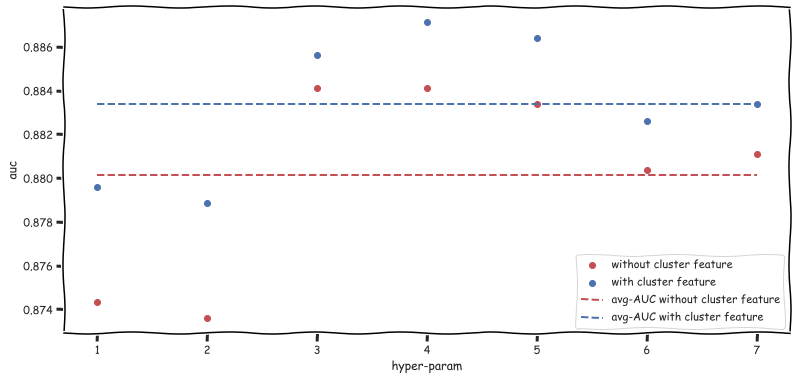

In [26]:
with plt.xkcd(): 
    plt.subplots(1, 1, figsize=(13,6))
    plt.scatter(x=np.array([1,2,3,4,5,6,7]),y=np.array(auc),color='r',label='without cluster feature')
    plt.scatter(x=np.array([1,2,3,4,5,6,7]),y=np.array(uns_auc),color='b',label='with cluster feature')

    plt.hlines(np.array(auc).mean(), xmin=1, xmax=7, colors='r', linestyles='--', label='avg-AUC without cluster feature')
    plt.hlines(np.array(uns_auc).mean(), xmin=1, xmax=7, colors='b', linestyles='--', label='avg-AUC with cluster feature')

    plt.xlabel('hyper-param')
    plt.ylabel('auc')
    plt.legend(loc='lower right')

### 4.3.3 conclusion

 - yes! unsupervised-learning can improve performance in this problem.
 - there are 7 out of 7 trails that unsupervied-learning features can improve performance.

## 4.4 cluster changing-- time series analysis

#### a.use projects in 2017 to create our cluster centers
#### b.keep those centers un-changed, and see other years cluster

### 4.4.1 data-preprocess (same as before)

In [27]:
df=pd.read_csv('Data/Data_I-hope.csv')
df = df[(df["ProjectStage"] == 'Complete')]
df = df.dropna(subset=['PlanFinishDate'])

mi_holidays = holidays.UnitedStates(state='MI')
start = df['PlanStartDate'].astype(str)
end = df['ActualFinishDate'].astype(str)
bus = []
holi = []
dur = []
start_list = start.tolist()
end_list = end.tolist()
for i in range(len(start_list)):
    holi.append(len(mi_holidays[start_list[i]: end_list[i]]))
    bus.append(np.busday_count(start_list[i], end_list[i]))

zip_object = zip(bus, holi)
for list1_i, list2_i in zip_object:
    dur.append(list1_i-list2_i)
df['Duration'] = dur


def met_sla(df):
    if df['Duration'] <= df['SLA']:
        val = 1
    elif df['Duration'] > df['SLA']:
        val = 0
    return val
df['Met_SLA'] = df.apply(met_sla, axis=1)

duration = []
for item in df['Duration'].to_list():
    if abs(int(item)) >=0 and abs(int(item)) < 50:
        duration.append(1)
    elif abs(int(item)) >=50 and abs(int(item)) < 100:
        duration.append(2)
    elif abs(int(item)) >=100 and abs(int(item)) < 150:
        duration.append(3)
    elif abs(int(item)) >=150 and abs(int(item)) < 200:
        duration.append(4)
    elif abs(int(item)) >=200 and abs(int(item)) < 250:
        duration.append(5)
    elif abs(int(item)) >=250 and abs(int(item)) < 300:
        duration.append(6)
    elif abs(int(item)) >=300 and abs(int(item)) < 350:
        duration.append(7)
    elif abs(int(item)) >=350 and abs(int(item)) < 400:
        duration.append(8)
    elif abs(int(item)) >=400:
        duration.append(9)
df['DurationCat'] = duration

df=df.rename(columns={"CategoryID_y": "CategoryID","Division_y":"Division"})
keep_cols=['Met_SLA','SLA','Hours','ProjectType','CreatedBy','Division','CategoryID',
            'BuyerName','Planned','LevelCalc','WorkPerformedFor','FedReview','DurationCat']

df=df[keep_cols+['CreateDate']]
df['CreateDate']=df['CreateDate'].str[:4].astype(np.int)


#==============================================================================
for col in num_cols:
    df[col]=pd.to_numeric(df[col],errors='coerce')
    df[col]=df[col].fillna(-1)
    
    upper_=df[col].quantile(0.95)
    lower_=df[col].quantile(0.05)
    df.loc[df[col]>upper_,col]=upper_
    df.loc[df[col]<lower_,col]=lower_

    min_=df[col].min()
    df[col]=np.log(df[col]-min_+1)
    
    min_=df[col].min()
    max_=df[col].max()
    df[col]=(df[col]-min_)/(max_-min_)*2 # *2:increase influence by continue variables when clustering
       
for col in cat_cols:
    tmp=df.groupby([col]).agg({'Met_SLA':'count'})
    keep_group=list(tmp[tmp['Met_SLA']>=100].index)
    df.loc[~df[col].isin(keep_group),col]='other'
    
#===================================================================================
df=pd.get_dummies(df, columns=cat_cols, drop_first=False)
print(df.shape)
df.head(3)

(4026, 70)


,SLA,Hours,LevelCalc,DurationCat,CreateDate,Met_SLA_0,Met_SLA_1,ProjectType_CN,ProjectType_RFP,ProjectType_other,...,WorkPerformedFor_271,WorkPerformedFor_313,WorkPerformedFor_391,WorkPerformedFor_472,WorkPerformedFor_491,WorkPerformedFor_551,WorkPerformedFor_591,WorkPerformedFor_other,FedReview_False,FedReview_other
1,1.175884,0.914744,0.0,1.0,2017,1,0,1,0,0,...,0,0,0,0,0,0,0,1,1,0
2,1.175884,1.034511,0.0,0.0,2017,0,1,1,0,0,...,0,0,0,0,0,0,0,1,1,0
3,1.175884,0.914744,0.0,0.0,2017,0,1,1,0,0,...,0,0,1,0,0,0,0,0,1,0


In [28]:
x_2017=np.array(df[df['CreateDate']==2017])
x_2018=np.array(df[df['CreateDate']==2018])
x_2019=np.array(df[df['CreateDate']==2019])
x_2020=np.array(df[df['CreateDate']==2020])
x_2021=np.array(df[df['CreateDate']==2021])
x_2022=np.array(df[df['CreateDate']==2022])

rawdata_dict={'2017':x_2017,'2018':x_2018,'2019':x_2019,
              '2020':x_2020,'2021':x_2021,'2022':x_2022}

### 4.4.2 build model

In [29]:
mean_share=np.mean(x_2017,axis=0)
std_share=np.std(x_2017,axis=0)
x_2017_z=(x_2017-mean_share)/(std_share+1e-10)

pca_share=PCA(n_components=2)
x_2017_pca=pca_share.fit_transform(x_2017_z)

km_share=KMeans(n_clusters=3, random_state=0)
x_2017_cluster=km_share.fit_predict(x_2017_z)

#-------------------------------------------------
zdata_dict={}
for key in rawdata_dict:
    zdata_dict[key]=(rawdata_dict[key]-mean_share)/(std_share+1e-10)
    
#-------------------------------------------------
pcadata_dict={}
for key in zdata_dict:
    pcadata_dict[key]=pca_share.transform(zdata_dict[key])
    
#-------------------------------------------------
cdata_dict={}
for key in zdata_dict:
    cdata_dict[key]=km_share.predict(zdata_dict[key])

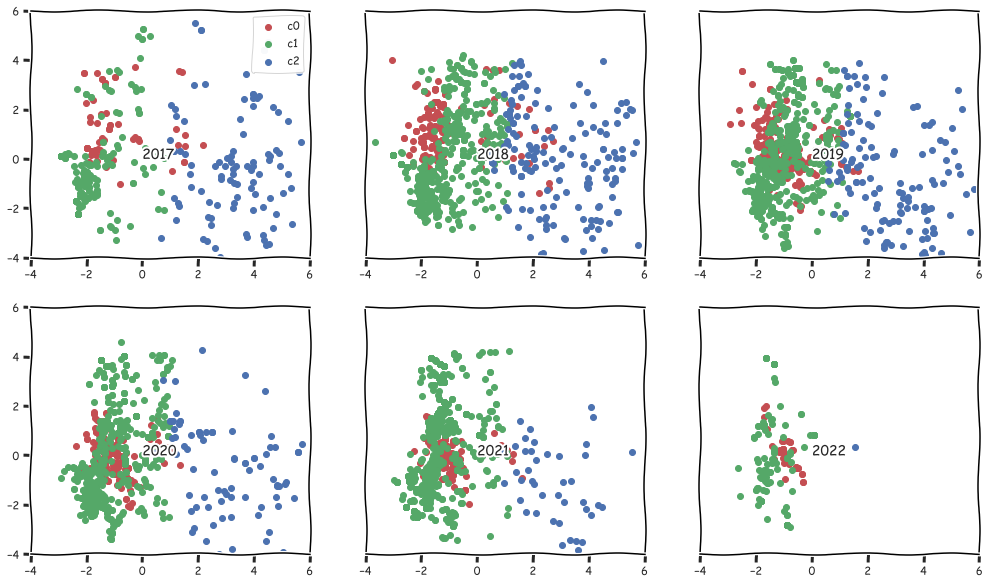

In [30]:
index_=np.array([['2017','2018','2019'],['2020','2021','2022']])
with plt.xkcd(): 
    plt.close()
    fig, axs = plt.subplots(2, 3, figsize=(17,10))
    
    for i,j in [[0,0],[0,1],[0,2],[1,0],[1,1],[1,2]]:
        year=index_[i,j]
        
        tmp_pca=pcadata_dict[year]
        tmp_c=cdata_dict[year]
        tmp=pd.DataFrame(np.concatenate([tmp_pca,tmp_c.reshape(-1,1)],axis=1),
                         columns=['x','y','cluster'])
        
        axs[i,j].scatter(tmp[tmp['cluster']==0]['x'],tmp[tmp['cluster']==0]['y'],color='r',label='c0')
        axs[i,j].scatter(tmp[tmp['cluster']==1]['x'],tmp[tmp['cluster']==1]['y'],color='g',label='c1')
        axs[i,j].scatter(tmp[tmp['cluster']==2]['x'],tmp[tmp['cluster']==2]['y'],color='b',label='c2')
        
        axs[i,j].set_xlim(-4,6)
        axs[i,j].set_ylim(-4,6)
        axs[i,j].annotate(year, xy=(0,0), xytext=(0, 0), xycoords="data",)
        
        if i==0 and j==0:
            axs[i,j].legend(loc='upper right')
            
        if j>0:
            axs[i,j].tick_params(left=False,labelleft=False)

### 4.4.3 explore cluster-2  & conclusion

In [31]:
tmp=df[df['CreateDate']==2017].copy(deep=True)
tmp['cluster']=cdata_dict['2017']
tmp['mark']=1

#-------------------------------------
observe_cols=['SLA','Hours','DurationCat']

print('========important continue variables===============')
print('all--------------')
print(tmp[observe_cols].describe())
print('')
print('cluster 2--------')
print(tmp[tmp['cluster']==2][observe_cols].describe())

========important continue variables===============
all--------------
              SLA       Hours  DurationCat
count  344.000000  344.000000   344.000000
mean     1.378657    1.095003     0.630709
std      0.370379    0.541215     0.809942
min      0.000000    0.288570     0.000000
25%      1.175884    0.914744     0.000000
50%      1.175884    0.914744     0.000000
75%      1.571239    1.286856     1.584963
max      2.000000    2.000000     2.000000

cluster 2--------
              SLA       Hours  DurationCat
count  104.000000  104.000000   104.000000
mean     1.817765    1.669666     1.665471
std      0.303694    0.562787     0.427684
min      1.175884    0.288570     0.000000
25%      1.571239    1.393937     1.584963
50%      2.000000    2.000000     2.000000
75%      2.000000    2.000000     2.000000
max      2.000000    2.000000     2.000000


In [32]:
observe_cols=['ProjectType_CN', 'ProjectType_RFP', 'ProjectType_other',
              'Division_COMM', 'Division_IT', 'Division_PROF', 'Division_other']
agg_dict={}
for col in observe_cols:
    agg_dict[col]=list(['mean'])

print('========important categorical variables===============')
print('all--------------')
print(tmp.groupby(['mark']).agg(agg_dict).reset_index().drop(('mark',''),axis=1))
print('')
print('cluster 2--------------')
print(tmp[tmp['cluster']==2].groupby(['mark']).agg(agg_dict).reset_index().drop(('mark',''),axis=1))

========important categorical variables===============
all--------------
  ProjectType_CN ProjectType_RFP ProjectType_other Division_COMM Division_IT  \
            mean            mean              mean          mean        mean   
0       0.712209        0.223837          0.063953      0.264535    0.177326   

  Division_PROF Division_other  
           mean           mean  
0       0.55814              0  

cluster 2--------------
  ProjectType_CN ProjectType_RFP ProjectType_other Division_COMM Division_IT  \
            mean            mean              mean          mean        mean   
0       0.144231        0.682692          0.173077      0.269231    0.298077   

  Division_PROF Division_other  
           mean           mean  
0      0.432692              0  


 - projects in cluster2 shinkage from 2019 to 2021.
 - projects in cluster2 tend to have bigger scale, it's SLA and Hours is higher than the whole group.
 - projects in cluster2 more likely RFP, and belongs to IT appartment.
 - so, big projects becoming fewer, it is not a good news. 